In [57]:
from typing import List, Union, TypeVar, Dict, Any, Optional, overload, Tuple

import matplotlib.pyplot as plt
import polars as pl
from glob import glob
import plotly.express as px
from plotly_resampler import register_plotly_resampler
import seaborn as sns
import panutil
from zipfile import ZipFile, ZIP_LZMA, ZIP_DEFLATED
import os
import numpy as np
from matplotlib.axes import Axes
from scipy.optimize import curve_fit
import seaborn.objects as so

theme = {
    **sns.axes_style("whitegrid"),
    "grid.linestyle": ":",
}
so.Plot.config.theme.update(**theme)

register_plotly_resampler(mode="auto")

In [2]:
def concat_results(fns: List[str], **kwargs):
    dfs = []
    for fn in fns:
        df = pl.read_csv(fn, skip_rows=6, **kwargs)
        if dfs:
            df = df.with_columns(
                pl.col("[run number]") + dfs[-1]["[run number]"].max() + 1
            )
        dfs.append(df)
    return pl.concat(dfs)


def parqify_results(
    fn_glob: str,
    csv_kwargs: Optional[Dict[str, Any]] = None,
    parq_kwargs: Optional[Dict[str, Any]] = None,
):
    csv_kwargs = csv_kwargs or dict()
    parq_kwargs = parq_kwargs or dict()

    single_fn = fn_glob.replace("*", "").replace(".csv", "")
    parq_fn = single_fn + ".parquet"
    zip_fn = single_fn + ".zip"
    try:
        return pl.read_parquet(parq_fn, **parq_kwargs)
    except Exception as e:
        fns = glob(fn_glob)
        fn_string = "\n\t".join(fns)
        print(f"Got {e}; reading CSVs:\n\t{fn_string}")
        results = concat_results(fns)
        print("Writing parquet")
        results.write_parquet(parq_fn)
        with ZipFile(zip_fn, "w", compression=ZIP_DEFLATED) as zip:
            print("Backing up to zip")
            for fn in fns:
                zip.write(fn)
            if zip.testzip() is None:
                print("Zip successful; removing CSVs")
                for fn in fns:
                    os.remove(fn)
            else:
                print("Zip failed; backup and remove manually")
        return results


sheep_see_order = ["none", "s", "w", "sw", "g", "sg", "wg", "swg"]
# wolves_see_order = ["none", "g", "w", "wg", "s", "sg", "sw", "swg"]
wolves_see_order = ["none", "s", "sg", "sw", "swg"]

In [3]:
sheep30x5 = parqify_results("data/2023-04-06-s-30x5-2000-sw-all-at-once-*.csv")
wolf30x5 = parqify_results("data/2023-04-06-w-30x5-2000-sw-all-at-once-*.csv")

In [ ]:
# px.line(
#     sheep30x5.filter(pl.col("[step]") > 1).with_columns(
#         [
#             pl.col("sheep-sim-l"),  # .cast(str),
#             pl.col("sheep-sim-n"),  # .cast(str),
#             pl.col("sheep-efficiency").over("[run number]"),
#         ]
#     )
#     .groupby(["[step]", "sheep-sim-n"])
#     .agg(pl.mean("sheep-efficiency"))
#     .sort(["sheep-sim-n", "[step]"])
#     .to_pandas(),
#     x="[step]",
#     y="sheep-efficiency",
#     color="sheep-sim-n",
#     # facet_row="sheep-sim-l"
# ).show()

px.box(
    sheep30x5.filter(pl.col("sheep-sim-n") < 10)
    # .groupby(["sheep-sim-l", "sheep-sim-n", "[run number]"])
    # .agg([
    #     # (pl.col("count wolves") > 0).sum(),
    #     (pl.mean("count wolves")),
    # ])
    # .groupby(["sheep-sim-l", "sheep-sim-n"])
    # .agg(pl.mean("count wolves"))
    .sort(["sheep-sim-n", "sheep-sim-l"])
    .to_pandas(),
    x="sheep-sim-n",
    y="count wolves",
    color="sheep-sim-l",
    points=False,

    # facet_row="sheep-sim-l"
).show()


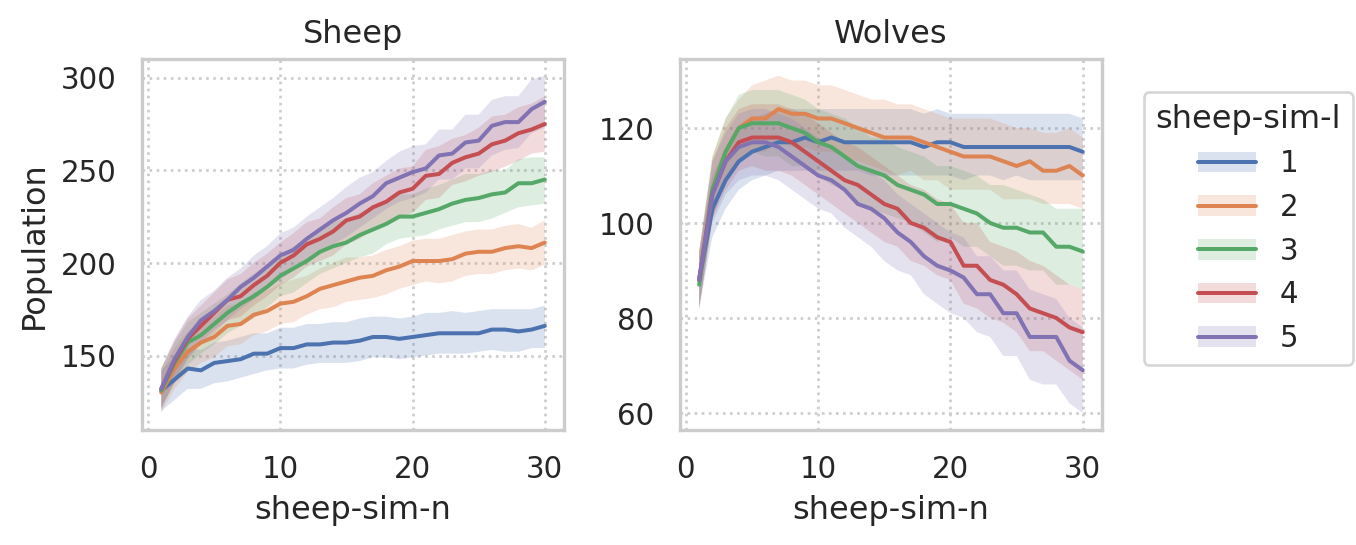

In [30]:
display(
    so.Plot(
        data=sheep30x5.filter(pl.col("[step]") > 1000)
        .melt(
            ["sheep-sim-n", "sheep-sim-l"],
            ["count sheep", "count wolves"],
            variable_name="species",
            value_name="Population",
        )
        .group_by("sheep-sim-n", "sheep-sim-l", "species")
        .agg(
            pl.median("Population"),
            low=pl.quantile("Population", 0.25),
            high=pl.quantile("Population", 0.75),
        )
        .with_columns(
            pl.col.species.map_dict({"count sheep": "Sheep", "count wolves": "Wolves"})
        ),
        x="sheep-sim-n",
        y="Population",
        ymin="low",
        ymax="high",
        color="sheep-sim-l",
    )
    .facet(col="species")
    .share(y=False)
    .add(so.Line())
    .add(so.Band())
    .scale(color=so.Nominal())
    .layout(size=(6, 3))
    .save("images/microsims-sheep-exp-pops.png", dpi=300, bbox_inches="tight")
)

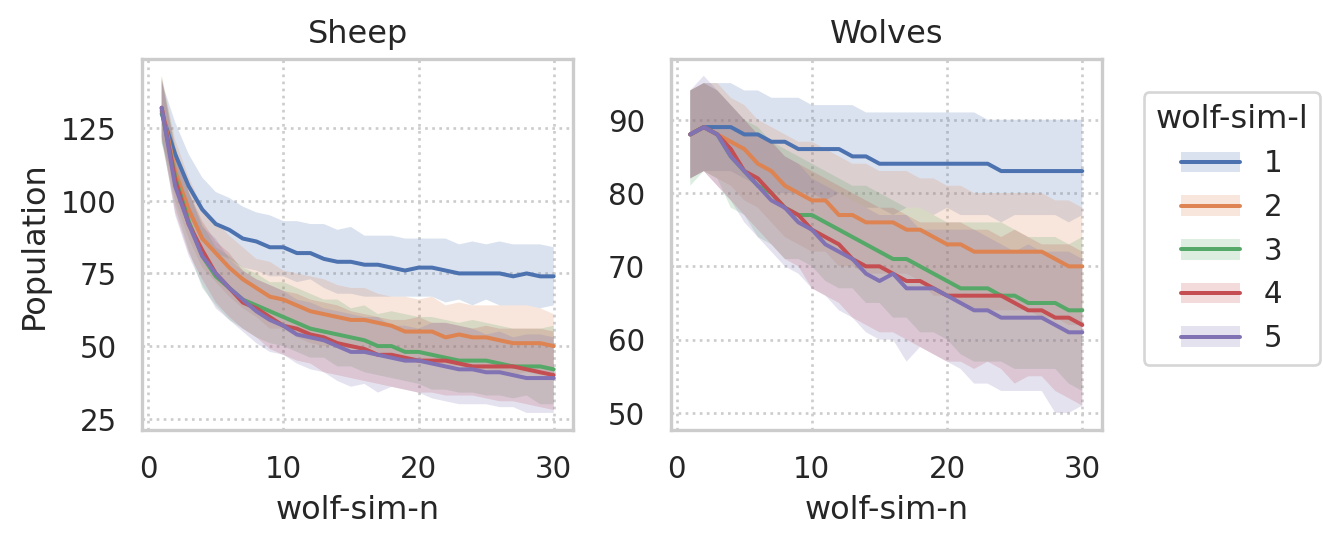

In [31]:
display(
    so.Plot(
        data=wolf30x5.filter(pl.col("[step]") > 1000)
        .melt(
            ["wolf-sim-n", "wolf-sim-l"],
            ["count sheep", "count wolves"],
            variable_name="species",
            value_name="Population",
        )
        .group_by("wolf-sim-n", "wolf-sim-l", "species")
        .agg(
            pl.median("Population"),
            low=pl.quantile("Population", 0.25),
            high=pl.quantile("Population", 0.75),
        )
        .with_columns(
            pl.col.species.map_dict({"count sheep": "Sheep", "count wolves": "Wolves"})
        ),
        x="wolf-sim-n",
        y="Population",
        ymin="low",
        ymax="high",
        color="wolf-sim-l",
    )
    .facet(col="species")
    .share(y=False)
    .add(so.Line())
    .add(so.Band())
    .scale(color=so.Nominal())
    .layout(size=(6, 3))
    .save("images/microsims-wolf-exp-pops.png", dpi=300, bbox_inches="tight")
)

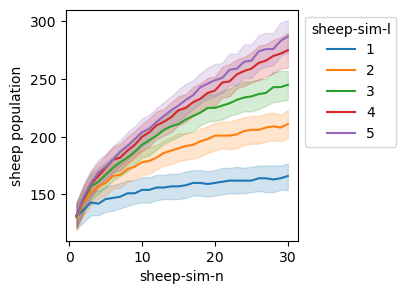

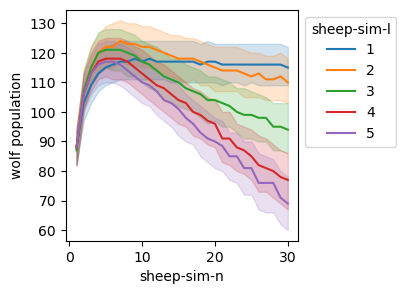

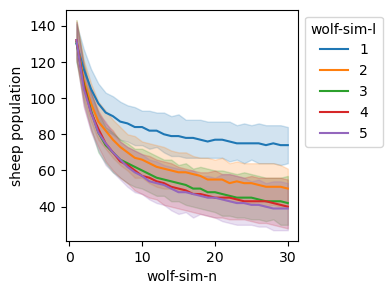

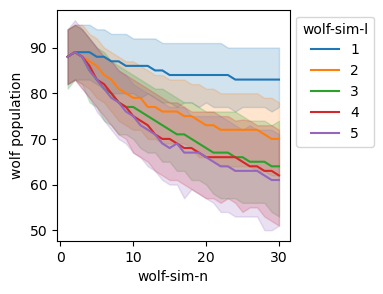

In [4]:
def plot_pop(df, sim_l, sim_n, count, label) -> Axes:
    plt.figure(figsize=(3, 3))
    ax = sns.lineplot(
        data=df.filter(pl.col("[step]") > 1000)
        .with_columns(pl.col(sim_l).cast(str))
        .to_pandas(),
        y=count,
        hue=sim_l,
        x=sim_n,
        errorbar=lambda xs: (np.quantile(xs, 0.25), np.quantile(xs, 0.75)),
        estimator="median",
        hue_order=df[sim_l].unique().cast(str).sort(),
    )
    ax.set(ylabel=label)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    return ax


plot_pop(
    sheep30x5, "sheep-sim-l", "sheep-sim-n", "count sheep", "sheep population"
).figure.savefig(
    "images/microsims-sheep-exp-sheep-pop.png", bbox_inches="tight", dpi=300
)
plot_pop(
    sheep30x5, "sheep-sim-l", "sheep-sim-n", "count wolves", "wolf population"
).figure.savefig(
    "images/microsims-sheep-exp-wolf-pop.png", bbox_inches="tight", dpi=300
)
plot_pop(
    wolf30x5, "wolf-sim-l", "wolf-sim-n", "count sheep", "sheep population"
).figure.savefig(
    "images/microsims-wolf-exp-sheep-pop.png", bbox_inches="tight", dpi=300
)
plot_pop(
    wolf30x5, "wolf-sim-l", "wolf-sim-n", "count wolves", "wolf population"
).figure.savefig("images/microsims-wolf-exp-wolf-pop.png", bbox_inches="tight", dpi=300)

In [33]:
@overload
def cumul_eff(pop: pl.Series, eff: pl.Series) -> float:
    ...


@overload
def cumul_eff(
    pop: Union[pl.Expr, pl.Series], eff: Union[pl.Expr, pl.Series]
) -> pl.Expr:
    ...


def cumul_eff(pop: Union[pl.Expr, pl.Series], eff: Union[pl.Expr, pl.Series]):
    # shift -1 because the efficiency of tick 3 was performed by the population
    # at the end of tick 2.
    # shift 1 to knock off the last pop, which didn't get a chance to eat
    # anything.
    return (eff.shift(-1) * pop).sum() / pop.shift(1).sum()


def stdize_out(
    value: pl.Expr, control_for: Union[str, pl.Expr, List[Union[pl.Expr, str]]]
) -> pl.Expr:
    return (value - value.mean().over(control_for)) / value.std().over(control_for)


@pl.api.register_expr_namespace("stat")
class Stat(object):
    def __init__(self, expr: pl.Expr):
        self._expr = expr

    def zscore(self) -> pl.Expr:
        return (self._expr - self._expr.mean()) / self._expr.std()

/tmp/ipykernel_437848/1124403403.py:27: UserWarning: Overriding existing custom namespace 'stat' (on 'Expr')
  @pl.api.register_expr_namespace("stat")


In [34]:
def summarize_runs(df: pl.DataFrame):
    return df.group_by("[run number]", maintain_order=True).agg(
        [
            pl.last("sheep-sim-n"),
            pl.last("sheep-sim-l"),
            pl.last("wolf-sim-n"),
            pl.last("wolf-sim-l"),
            pl.mean("count wolves").alias("mean_wolves"),
            pl.mean("count sheep").alias("mean_sheep"),
            pl.mean("grass").alias("mean_grass"),
            pl.col("[step]")
            .filter(pl.col("count wolves") > 0)
            .max()
            .alias("wolf_survival"),
            cumul_eff(pl.col("count sheep"), pl.col("sheep-efficiency")).alias(
                "sheep_eff"
            ),
            cumul_eff(pl.col("count wolves"), pl.col("sheep-escape-efficiency")).alias(
                "sheep_escape_eff"
            ),
            cumul_eff(pl.col("count wolves"), pl.col("wolf-efficiency")).alias(
                "wolf_eff"
            ),
        ]
    )


sheep_runs_bi = summarize_runs(sheep30x5.filter(pl.col("[step]") > 1000))
wolf_runs_bi = summarize_runs(wolf30x5.filter(pl.col("[step]") > 1000))
sheep_runs = summarize_runs(sheep30x5)
wolf_runs = summarize_runs(wolf30x5)

<Axes: xlabel='sheep-sim-n', ylabel='sheep survival rate'>

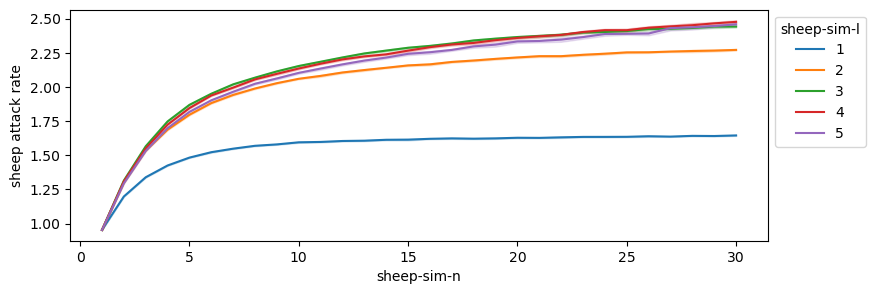

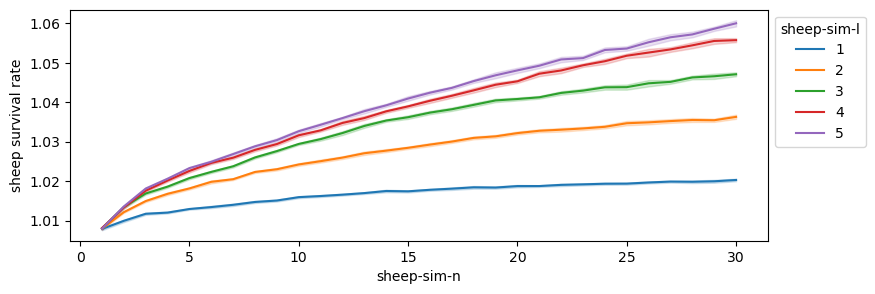

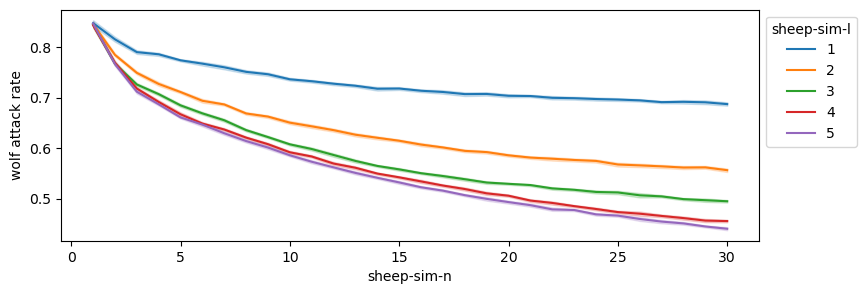

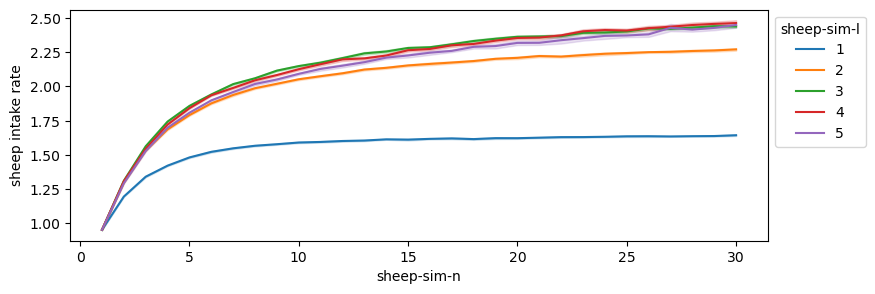

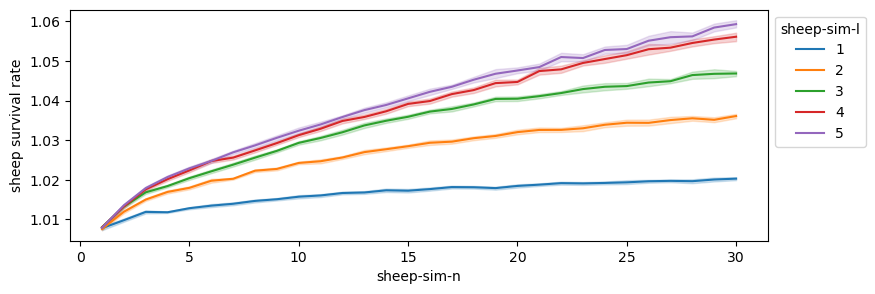

In [7]:
def plot_eff(df: pl.DataFrame, sim_l: str, sim_n: str, eff: str, label: str) -> Axes:
    plt.figure(figsize=(9, 3))
    ax = sns.lineplot(
        x=sim_n,
        y=eff,
        hue=sim_l,
        data=df.with_columns(pl.col(sim_l).cast(str)).to_pandas(),
        hue_order=df[sim_l].unique().sort().cast(str),
    )
    ax.set(ylabel=label)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    return ax


plot_eff(
    sheep_runs, "sheep-sim-l", "sheep-sim-n", "sheep_eff", "sheep attack rate"
).figure.savefig(
    "images/microsims_sheep_exp_sheep_eff.png", bbox_inches="tight", dpi=300
)

plot_eff(
    sheep_runs, "sheep-sim-l", "sheep-sim-n", "sheep_escape_eff", "sheep survival rate"
).figure.savefig(
    "images/microsims_sheep_exp_sheep_esc_eff.png", bbox_inches="tight", dpi=300
)

plot_eff(
    sheep_runs, "sheep-sim-l", "sheep-sim-n", "wolf_eff", "wolf attack rate"
).figure.savefig(
    "images/microsims_sheep_exp_wolf_eff.png", bbox_inches="tight", dpi=300
)
plot_eff(
    sheep_runs_bi, "sheep-sim-l", "sheep-sim-n", "sheep_eff", "sheep attack rate"
)
plot_eff(
    sheep_runs_bi, "sheep-sim-l", "sheep-sim-n", "sheep_escape_eff", "sheep survival rate"
)

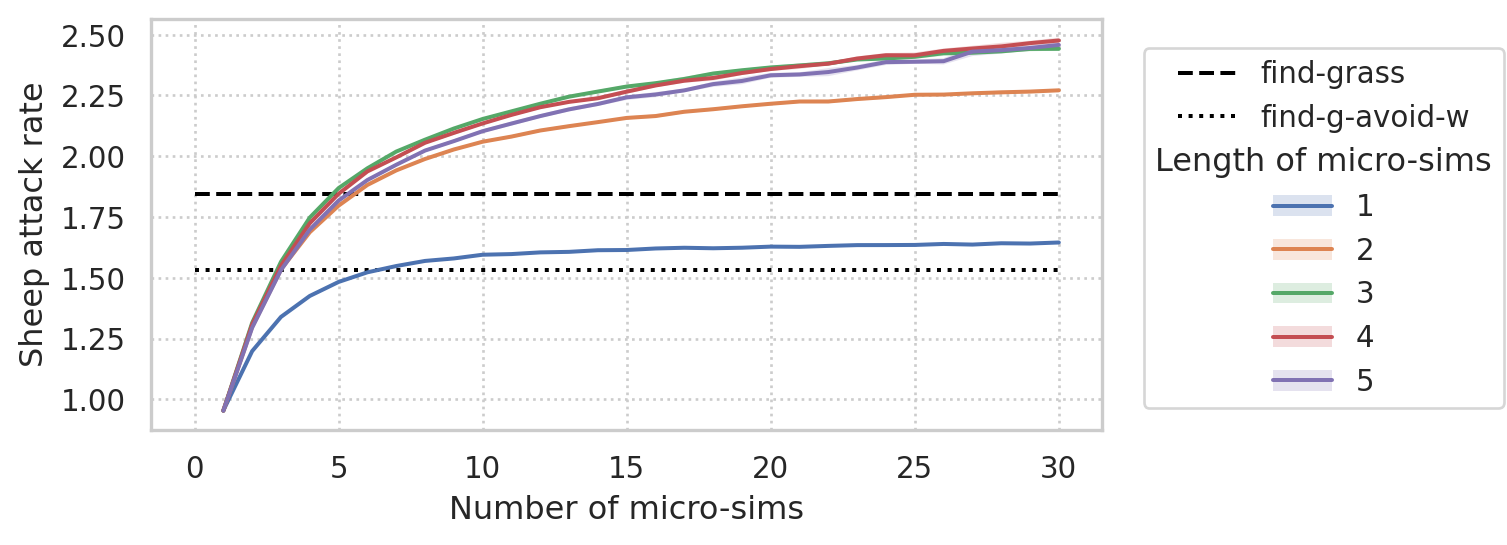

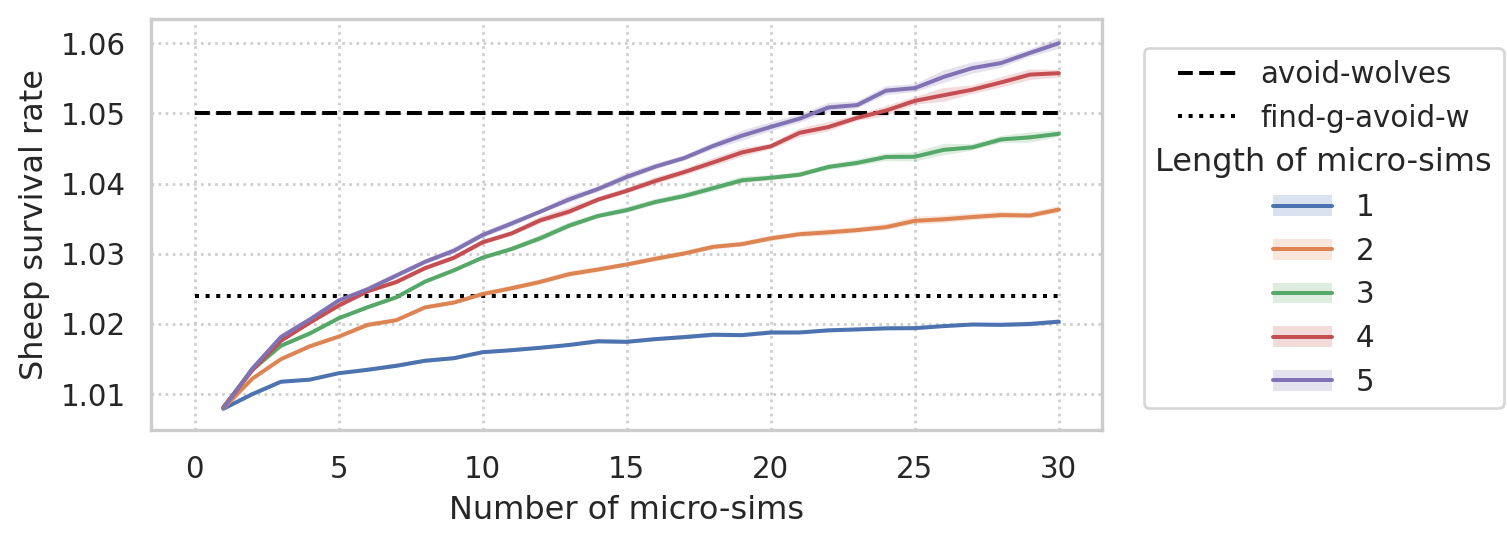

In [43]:
def manual(**variables):
    return {
        "data": pl.DataFrame(variables),
        **{k: k for k in variables},
    }


display(
    so.Plot(data=sheep_runs, x="sheep-sim-n", y="sheep_eff", color="sheep-sim-l")
    .add(
        so.Line(color="black", linestyle="--"),
        **manual(x=[0, 30], y=[1.846] * 2),
        label="find-grass",
    )
    .add(
        so.Line(color="black", linestyle=":"),
        **manual(x=[0, 30], y=[1.530] * 2),
        label="find-g-avoid-w",
    )
    .add(so.Line(), so.Agg())
    .add(so.Band(), so.Est())
    .scale(color=so.Nominal(order=[1, 2, 3, 4, 5]))
    .label(
        y="Sheep attack rate",
        x="Number of micro-sims",
        color="Length of micro-sims",
    )
    .layout(size=(6, 3))
    .save("images/microsims_sheep_exp_sheep_eff.png", bbox_inches="tight", dpi=300)
)
display(
    so.Plot(data=sheep_runs, x="sheep-sim-n", y="sheep_escape_eff", color="sheep-sim-l")
    .add(
        so.Line(color="black", linestyle="--"),
        **manual(x=[0, 30], y=[1.050] * 2),
        label="avoid-wolves",
    )
    .add(
        so.Line(color="black", linestyle=":"),
        **manual(x=[0, 30], y=[1.024] * 2),
        label="find-g-avoid-w",
    )
    .add(so.Line(), so.Agg())
    .add(so.Band(), so.Est())
    .scale(color=so.Nominal(order=[1, 2, 3, 4, 5]))
    .label(
        y="Sheep survival rate",
        x="Number of micro-sims",
        color="Length of micro-sims",
    )
    .layout(size=(6, 3))
    .save("images/microsims_sheep_exp_sheep_esc_eff.png", bbox_inches="tight", dpi=300)
)

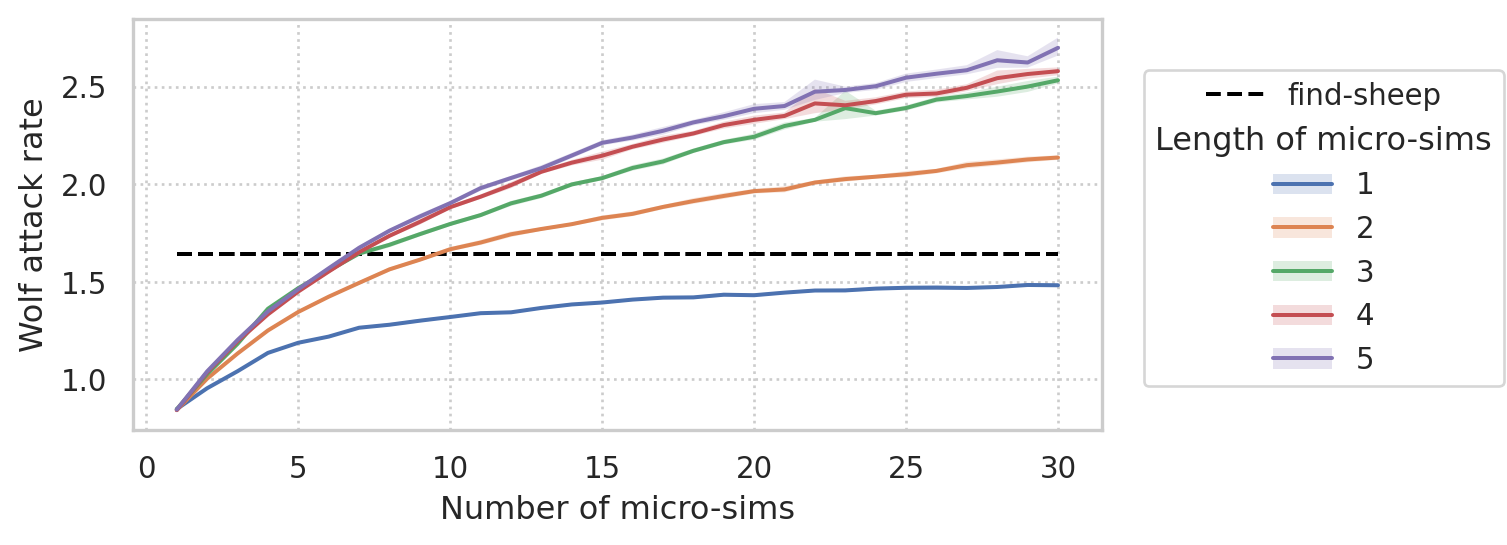

In [42]:
display(
    so.Plot(
        data=wolf_runs.with_columns(find_sheep=1.641),
        x="wolf-sim-n",
        y="wolf_eff",
        color="wolf-sim-l",
    )
    .add(
        so.Line(color="black", linestyle="--"),
        y="find_sheep",
        label="find-sheep",
    )
    .add(so.Line(), so.Agg())
    .add(so.Band(), so.Est())
    .scale(color=so.Nominal(order=[1, 2, 3, 4, 5]))
    .label(
        y="Wolf attack rate",
        x="Number of micro-sims",
        color="Length of micro-sims",
    )
    .layout(size=(6, 3))
    .save("images/microsims_wolf_exp_wolf_eff.png", bbox_inches="tight", dpi=300)
)

In [280]:
display(sheep_runs.sort("sheep-sim-l").pivot(
    values="sheep_eff", columns="sheep-sim-l", index="sheep-sim-n", aggregate_fn="mean"
).sort("sheep-sim-n"))
display(sheep_runs.sort("sheep-sim-l").pivot(
    values="sheep_escape_eff", columns="sheep-sim-l", index="sheep-sim-n", aggregate_fn="mean"
).sort("sheep-sim-n"))
display(wolf_runs.sort("wolf-sim-l").pivot(
    values="wolf_eff", columns="wolf-sim-l", index="wolf-sim-n", aggregate_fn="mean"
).sort("wolf-sim-n"))



sheep-sim-n,1,2,3,4,5
i64,f64,f64,f64,f64,f64
1,0.954059,0.953713,0.953053,0.953256,0.953052
2,1.198264,1.298722,1.314892,1.308383,1.294556
3,1.339014,1.534454,1.565728,1.550022,1.531773
4,1.425245,1.687411,1.747684,1.72428,1.698322
5,1.482939,1.796774,1.868958,1.845585,1.81771
6,1.522555,1.882004,1.950535,1.937576,1.902183
7,1.548327,1.941718,2.019171,1.995249,1.964854
8,1.569352,1.988789,2.068188,2.055476,2.023415
9,1.57958,2.02781,2.114063,2.096147,2.06223


sheep-sim-n,1,2,3,4,5
i64,f64,f64,f64,f64,f64
1,1.007861,1.007914,1.008039,1.008087,1.007927
2,1.009929,1.012127,1.013409,1.013333,1.013565
3,1.011711,1.014935,1.016852,1.017562,1.018104
4,1.012009,1.016769,1.018595,1.02014,1.020598
5,1.012926,1.018146,1.020765,1.022574,1.0233
6,1.013412,1.019818,1.022334,1.024608,1.024898
7,1.013986,1.020487,1.023756,1.025934,1.026853
8,1.014708,1.022319,1.025996,1.027918,1.028822
9,1.015072,1.023009,1.027609,1.029398,1.030397


wolf-sim-n,1,2,3,4,5
i64,f64,f64,f64,f64,f64
1,0.848427,0.843451,0.847426,0.842644,0.845255
2,0.954997,1.004125,1.027038,1.036404,1.041415
3,1.042044,1.132684,1.182171,1.19508,1.202182
4,1.136023,1.250807,1.36206,1.333321,1.348384
5,1.187987,1.345868,1.467614,1.450271,1.462242
6,1.219427,1.423827,1.557033,1.55267,1.56941
7,1.264867,1.494386,1.64476,1.651809,1.674222
8,1.280145,1.563841,1.689692,1.735541,1.761861
9,1.300942,1.613284,1.744124,1.807073,1.834715


[2.76906430e+03 2.74836085e+03 3.75624951e-03]
4.863469881677442e-07
1.0139859932349038
[9.28445770e+04 9.23894655e+04 8.75912613e-03]
1.7977909352207798e-06
1.0204874650076732
[3.25338419e+04 3.24499383e+04 1.23295065e-02]
4.2346398634022165e-06
1.0237557175350485
[1.12844970e+05 1.12856431e+05 1.49317013e-02]
1.0020299251225625e-05
1.0259341628089758
[1.85384046e+05 1.85572301e+05 1.59703090e-02]
1.1974996350467187e-05
1.0268525812107283


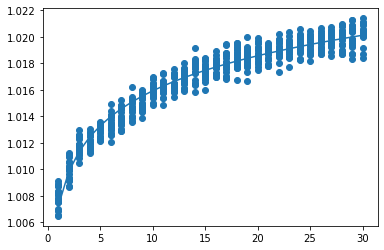

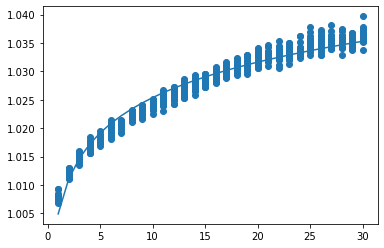

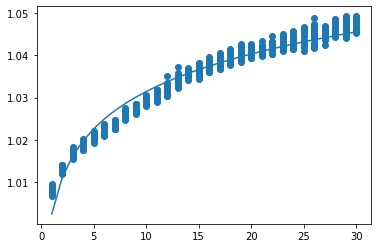

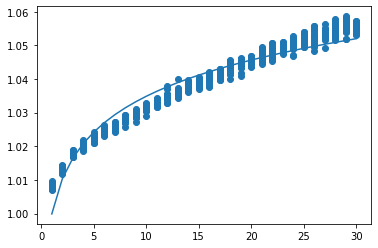

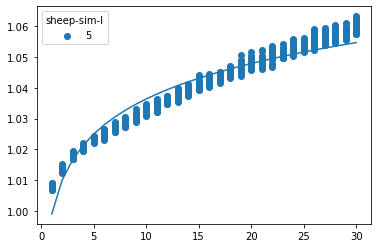

In [279]:
# # plot_eff(
# #     sheep_runs, "sheep-sim-l", "sheep-sim-n", "sheep_eff", "sheep intake rate"
# # )
# sns.scatterplot(
#     sheep_runs.sort("sheep-sim-l").with_columns(pl.col("sheep-sim-l").cast(str)).to_pandas(),
#     x="sheep-sim-n",
#     y="sheep_eff",
#     hue="sheep-sim-l",
# )


def asymptotic_f(x, a, b, n):
    return a * x ** n / (x ** n + b)


# def asymptotic_f(x, b0, b1, lrc):
#     return b0 + b1 * (1-np.exp(-np.exp(lrc) * x))
# def asymptotic_f(x, a, b, c):
#     return a - (a - b) * np.exp(-c * x)
for l in sheep_runs["sheep-sim-l"].sort().unique():
    plt.figure()
    y, x = (
        sheep_runs.filter((pl.col("sheep-sim-l") == l))
        .select(["sheep_escape_eff", "sheep-sim-n"])
        .sort("sheep-sim-n")
        .to_numpy()
        .T
    )
    plt.scatter(x, y, label=l)
    popt, pcov = curve_fit(asymptotic_f, x, y, maxfev=2000)
    xs = np.linspace(1, 100, 100)
    plt.plot(x, asymptotic_f(x, *popt))
    print(popt)
    print(np.sum((asymptotic_f(x, *popt) - y) ** 2) / len(y))
    print(
        sheep_runs.filter((pl.col("sheep-sim-l") == l) & (pl.col("sheep-sim-n") == 7))["sheep_escape_eff"].mean()
    )
    # print(np.sum((y - asymptotic_f(x, *popt)) ** 2 / ))
plt.legend(title="sheep-sim-l")


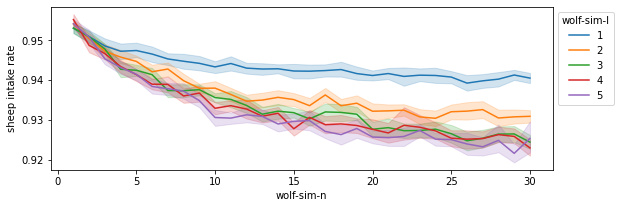

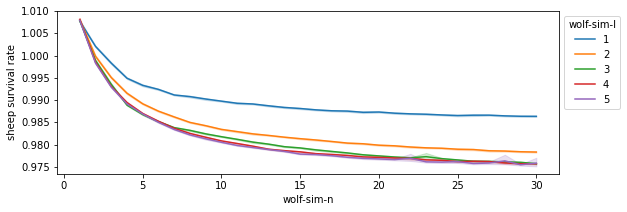

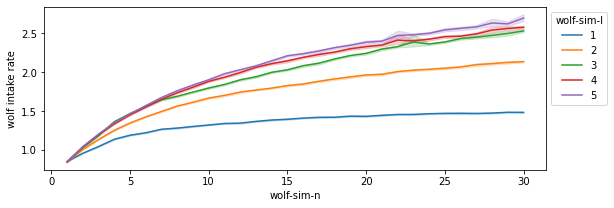

In [140]:
plot_eff(
    wolf_runs, "wolf-sim-l", "wolf-sim-n", "sheep_eff", "sheep intake rate"
).figure.savefig(
    "images/microsims_wolf_exp_sheep_eff.png", bbox_inches="tight", dpi=300
)
plot_eff(
    wolf_runs, "wolf-sim-l", "wolf-sim-n", "sheep_escape_eff", "sheep survival rate"
).figure.savefig(
    "images/microsims_wolf_exp_sheep_esc_eff.png", bbox_inches="tight", dpi=300
)
plot_eff(
    wolf_runs, "wolf-sim-l", "wolf-sim-n", "wolf_eff", "wolf intake rate"
).figure.savefig("images/microsims_wolf_exp_wolf_eff.png", bbox_inches="tight", dpi=300)


In [44]:
perception_sweep = parqify_results(
    "data/2023-01-20-s-n_3_6_9-l_3-w-n_3_9_30-l_5-perception-sweep*.csv"
).filter((pl.col("sheep-sim-n") == 9) & (pl.col("wolf-sim-n") == 9))

In [47]:
perception_sweep = perception_sweep.with_columns(
    [
        sum(
            (
                pl.when(pl.col(f"{species}-see-{agents}?"))
                .then(pl.lit(agents[0]))
                .otherwise(pl.lit(""))
                for agents in ["sheep", "wolves", "grass"]
            ),
            start=pl.lit(""),
        )
        .alias(f"{species}-see")
        .str.replace("^$", "none")
        for species in ["sheep", "wolves"]
    ]
)

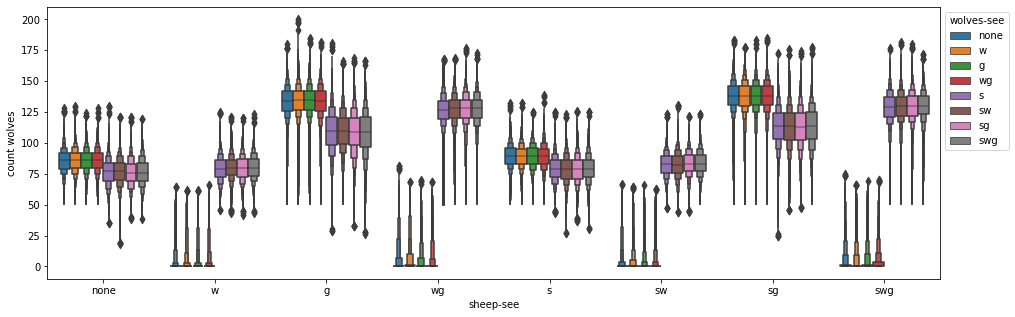

In [107]:

# px.box(
#     perception_sweep
#     .sort(["sheep-sim-n", "sheep-sim-l"])
#     .to_pandas(),
#     facet_col="sheep-sim-n",
#     facet_row="wolf-sim-n",
#     x="sheep-see",
#     y="count wolves",
#     color="wolves-see",
#     points=False,
#     # facet_row="sheep-sim-l"
# ).show()
# sns.FacetGrid(
#     perception_sweep.to_pandas(),
#     row="sheep-sim-n",
#     col="wolf-sim-n",
#     aspect=2,
# ).map_dataframe(
#     sns.boxenplot,
#     x="sheep-see",
#     y="count wolves",
#     hue="wolves-see",
#     palette=sns.color_palette(),
# ).add_legend()
plt.figure(figsize=(16, 5))
ax = sns.boxenplot(
    perception_sweep.to_pandas(),
    x="sheep-see",
    y="count wolves",
    hue="wolves-see",
    palette=sns.color_palette(),
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


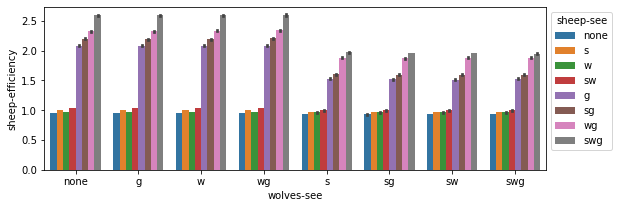

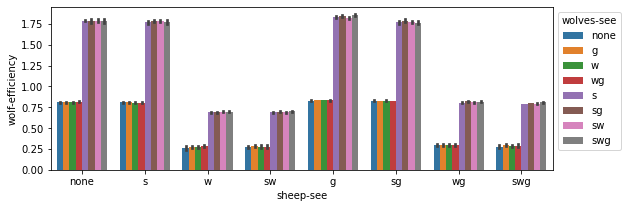

In [145]:
df = (
    perception_sweep.groupby(
        ["sheep-sim-n", "wolf-sim-n", "sheep-see", "wolves-see", "[run number]"]
    )
    .agg(
        [
            cumul_eff(pl.col("count sheep"), pl.col("sheep-efficiency")),
            cumul_eff(pl.col("count wolves"), pl.col("wolf-efficiency")),
        ]
    )
    .sort(["sheep-see", "wolves-see"])
)
# sns.FacetGrid(df, row="sheep-sim-n", col="wolf-sim-n", aspect=2,).map_dataframe(
#     sns.barplot,
#     hue="sheep-see",
#     y="sheep-efficiency",
#     x="wolves-see",
#     hue_order=sheep_see_order,
#     order=sheep_see_order,
#     palette=sns.color_palette(),
# ).add_legend()

# sns.FacetGrid(df, row="sheep-sim-n", col="wolf-sim-n", aspect=2,).map_dataframe(
#     sns.barplot,
#     x="sheep-see",
#     y="wolf-efficiency",
#     hue="wolves-see",
#     order=sheep_see_order,
#     hue_order=sheep_see_order,
#     palette=sns.color_palette(),
# ).add_legend()
plt.figure(figsize=(9, 3))
ax = sns.barplot(
    df.to_pandas(),
    hue="sheep-see",
    y="sheep-efficiency",
    x="wolves-see",
    hue_order=sheep_see_order,
    order=wolves_see_order,
    palette=sns.color_palette(),
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.figure(figsize=(9, 3))
ax = sns.barplot(
    df.to_pandas(),
    x="sheep-see",
    y="wolf-efficiency",
    hue="wolves-see",
    order=sheep_see_order,
    hue_order=wolves_see_order,
    palette=sns.color_palette(),
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [50]:
wudf = parqify_results(
    "data/2023-04-06-s-wu_0_6-n_12-l_3-w-wu_0_6-n_12-l_3-perception-sweep-all-at-once*.csv"
).with_columns(
    [
        sum(
            (
                pl.when(pl.col(f"{species}-see-{agents}?"))
                .then(pl.lit(agents[0]))
                .otherwise(pl.lit(""))
                for agents in ["sheep", "wolves", "grass"]
            ),
            start=pl.lit(""),
        )
        .alias(f"{species}-see")
        .str.replace("^$", "none")
        for species in ["sheep", "wolves"]
    ]
)

In [51]:
wudf_runs = wudf.group_by(
    [
        "[run number]",
        "wolves-see",
        "sheep-see",
        "sheep-sim-warmup",
        "sheep-sim-n",
        "wolf-sim-warmup",
        "wolf-sim-n",
    ]
).agg(
    [
        cumul_eff(pl.col("count sheep"), pl.col("sheep-efficiency")),
        cumul_eff(pl.col("count wolves"), pl.col("sheep-escape-efficiency")),
        cumul_eff(pl.col("count wolves"), pl.col("wolf-efficiency")),
        pl.mean("count sheep").alias("sheep-pop"),
        pl.mean("count wolves").alias("wolf-pop"),
        pl.mean("grass").alias("grass-pop"),
    ]
)

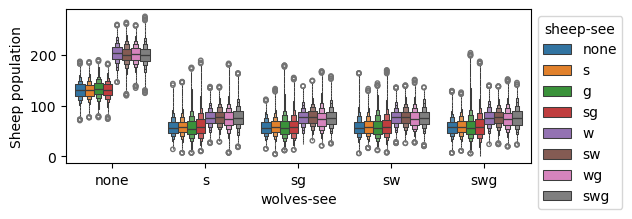

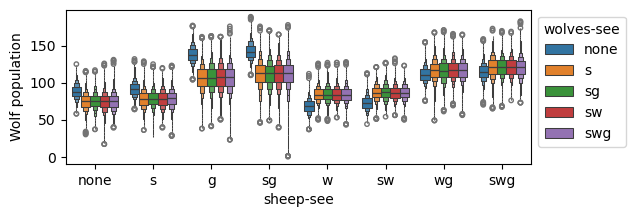

In [59]:
def plot_pop_dists(
    df: pl.DataFrame,
    x: Tuple[str, List[str]],
    hue: Tuple[str, List[str]],
    y: Tuple[str, str],
) -> Axes:
    plt.figure(figsize=(6, 2))
    ax = sns.boxenplot(
        df,
        x=x[0],
        y=y[0],
        hue=hue[0],
        order=x[1],
        hue_order=hue[1],
        # palette=sns.color_palette(),
        flier_kws={"s": 10},
    )
    ax.set_ylabel(y[1])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    return ax


wso_pop = ["none", "s", "sg", "sw", "swg"]
sso_pop = ["none", "s", "g", "sg", "w", "sw", "wg", "swg"]
wudf_no_wu = wudf.filter(
    (pl.col("[step]") > 1000)
    & (pl.col("sheep-sim-warmup") == 0)
    & (pl.col("wolf-sim-warmup") == 0)
)
plot_pop_dists(
    wudf_no_wu,
    ("wolves-see", wso_pop),
    ("sheep-see", sso_pop),
    ("count sheep", "Sheep population"),
).figure.savefig(
    "images/microsims_sees_exp_sheep_pop.png", bbox_inches="tight", dpi=300
)
plot_pop_dists(
    wudf_no_wu,
    ("sheep-see", sso_pop),
    ("wolves-see", wso_pop),
    ("count wolves", "Wolf population"),
).figure.savefig("images/microsims_sees_exp_wolf_pop.png", bbox_inches="tight", dpi=300)

sheep warmup 0; wolf warmup 0
sheep warmup 0; wolf warmup 6
sheep warmup 6; wolf warmup 0
sheep warmup 6; wolf warmup 6


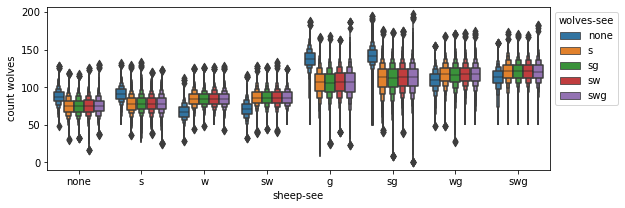

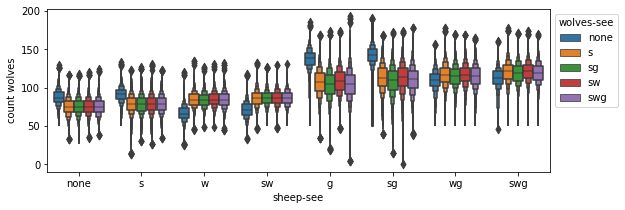

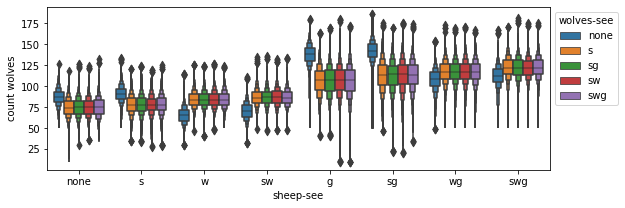

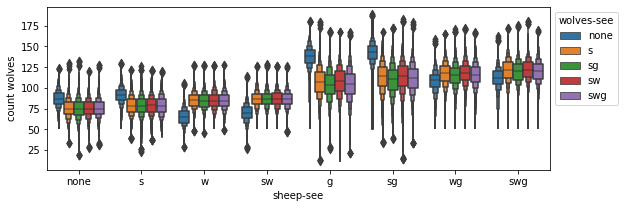

In [161]:
for sheep_wu in wudf["sheep-sim-warmup"].unique():
    for wolf_wu in wudf["wolf-sim-warmup"].unique():
        print(f"sheep warmup {sheep_wu}; wolf warmup {wolf_wu}")
        plt.figure(figsize=(9, 3))
        ax = sns.boxenplot(
            wudf.filter(
                (pl.col("sheep-sim-warmup") == sheep_wu)
                & (pl.col("wolf-sim-warmup") == wolf_wu)
            ).to_pandas(),
            x="sheep-see",
            y="count wolves",
            hue="wolves-see",
            hue_order=wolves_see_order,
            order=sheep_see_order,
            palette=sns.color_palette(),
        )
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


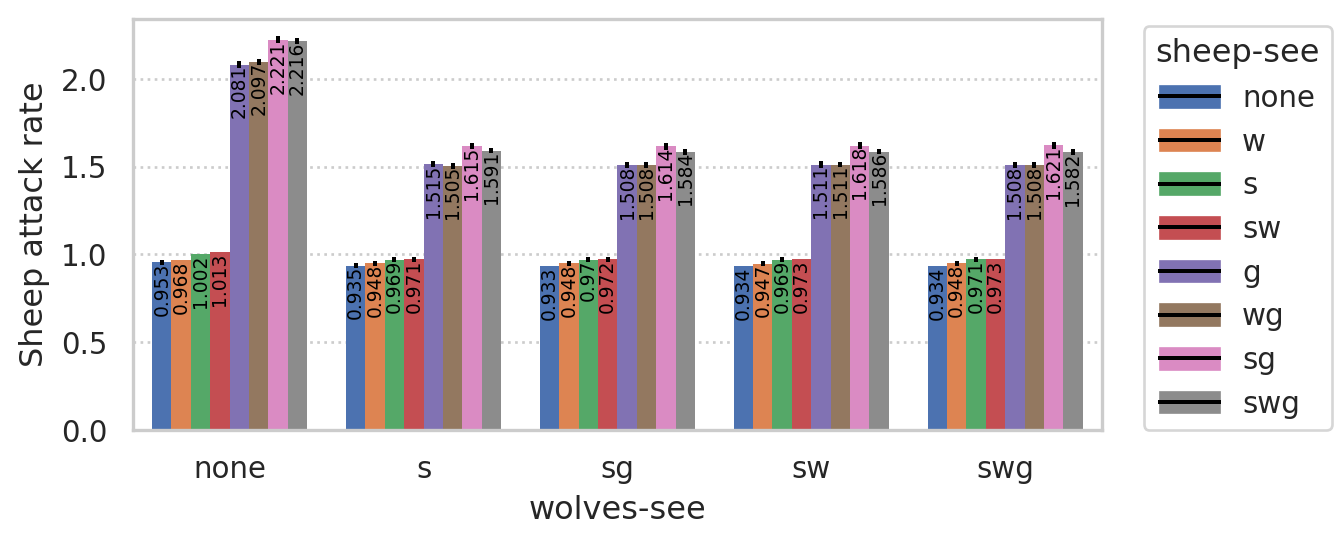

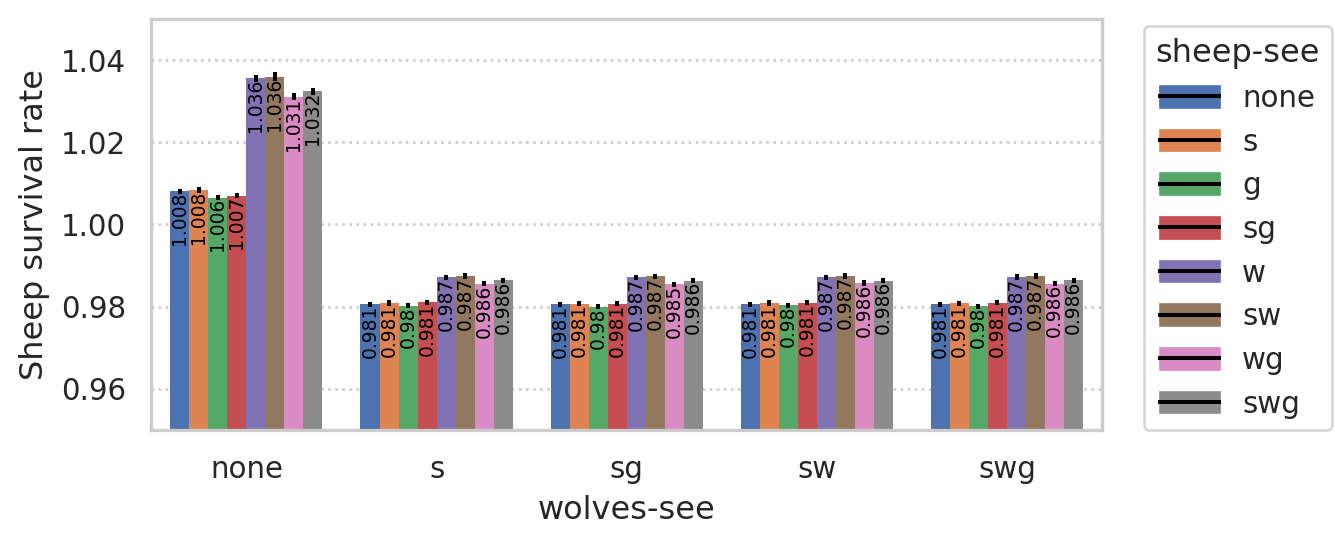

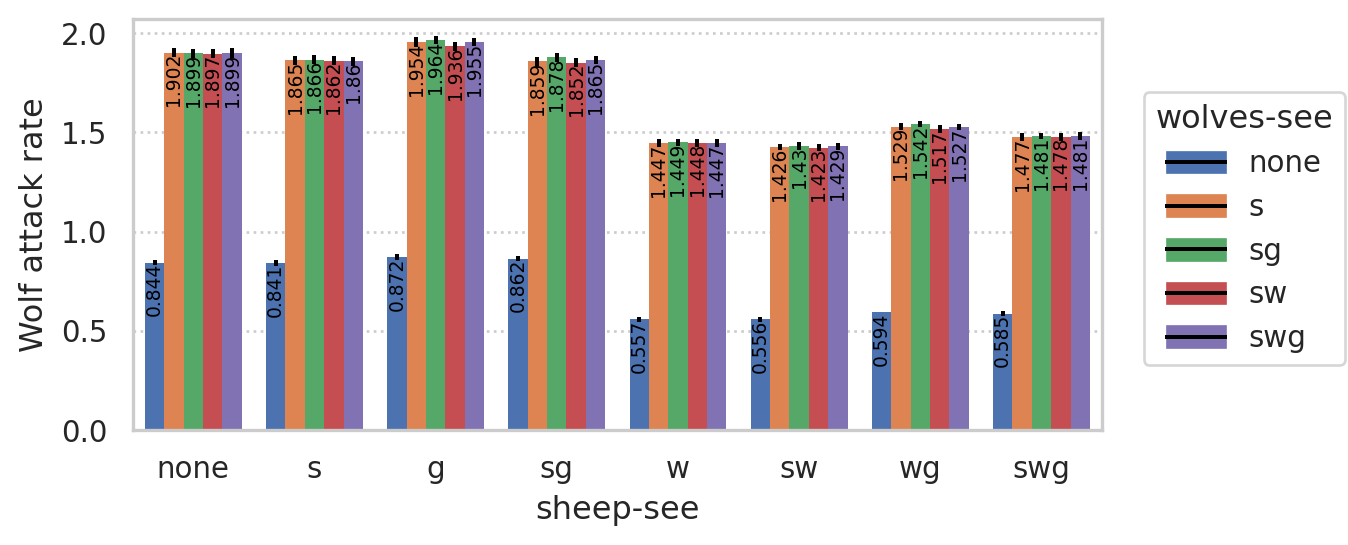

In [99]:
def bootstrap_ci(expr: pl.Expr, n=1000, level=0.95) -> pl.Expr:
    def calc_cis(series: pl.Series):
        seed = abs(hash(series.view().data.tobytes()))
        means = (
            series.sample(fraction=n, with_replacement=True, seed=seed)
            .reshape((n, -1))
            .list.mean()
        )
        return dict(
            lower=means.quantile((1 - level) / 2),
            upper=means.quantile((1 + level) / 2),
            count=len(means),
        )

    return expr.map_elements(calc_cis)


def plot_eff_over_sees(
    df: pl.DataFrame,
    eff: Tuple[str, str],
    x: Tuple[str, List[Any]],
    hue: Tuple[str, List[Any]],
    precision=3,
    fontsize=7,
    figsize=(6, 3),
    offset=0,
    legend=True,
) -> so.Plot:
    agg = (
        df.group_by(x[0], hue[0])
        .agg(
            mean=pl.mean(eff[0]),
            eff_range=pl.col(eff[0]).pipe(bootstrap_ci, level=0.95),
        )
        .with_columns(
            upper=pl.col.eff_range.struct["upper"],
            lower=pl.col.eff_range.struct["lower"],
            rounded=pl.col.mean.round(precision),
        )
        .select(pl.all().exclude("eff_range"))
    )
    return (
        so.Plot(
            data=agg,
            x=x[0],
            y="mean",
            color=hue[0],
            text="rounded",
            ymin="lower",
            ymax="upper",
        )
        .add(so.Bar(alpha=1), so.Dodge(by=["color"]), legend=legend)
        .add(so.Range(color="black"), so.Dodge(by=["color"]), legend=legend)
        .add(
            so.Text(
                {"rotation": 90},
                valign="top",
                color="black",
                fontsize=fontsize,
                offset=offset,
            ),
            so.Dodge(by=["color"]),
            legend=legend,
        )
        .layout(size=figsize)
        .scale(x=so.Nominal(order=x[1]), color=so.Nominal(order=hue[1]))
        .label(y=eff[1])
    )


sso_eff = ["none", "w", "s", "sw", "g", "wg", "sg", "swg"]
wso_eff = ["none", "s", "sg", "sw", "swg"]

wudf_run_no_wu = wudf_runs.filter(
    (pl.col("sheep-sim-warmup") == 0) & (pl.col("wolf-sim-warmup") == 0)
)
display(
    plot_eff_over_sees(
        wudf_run_no_wu,
        ("sheep-efficiency", "Sheep attack rate"),
        ("wolves-see", wso_eff),
        ("sheep-see", sso_eff),
    ).save("images/microsims_sees_exp_sheep_eff.png", bbox_inches="tight", dpi=300)
)

display(
    plot_eff_over_sees(
        wudf_run_no_wu,
        ("sheep-escape-efficiency", "Sheep survival rate"),
        ("wolves-see", wso_eff),
        ("sheep-see", sso_pop),
    )
    .limit(y=(0.95, 1.05))
    .save("images/microsims_sees_exp_sheep_esc_eff.png", bbox_inches="tight", dpi=300)
)

display(
    plot_eff_over_sees(
        wudf_run_no_wu,
        ("wolf-efficiency", "Wolf attack rate"),
        ("sheep-see", sso_pop),
        ("wolves-see", wso_eff),
    ).save("images/microsims_sees_exp_wolf_eff.png", bbox_inches="tight", dpi=300)
)

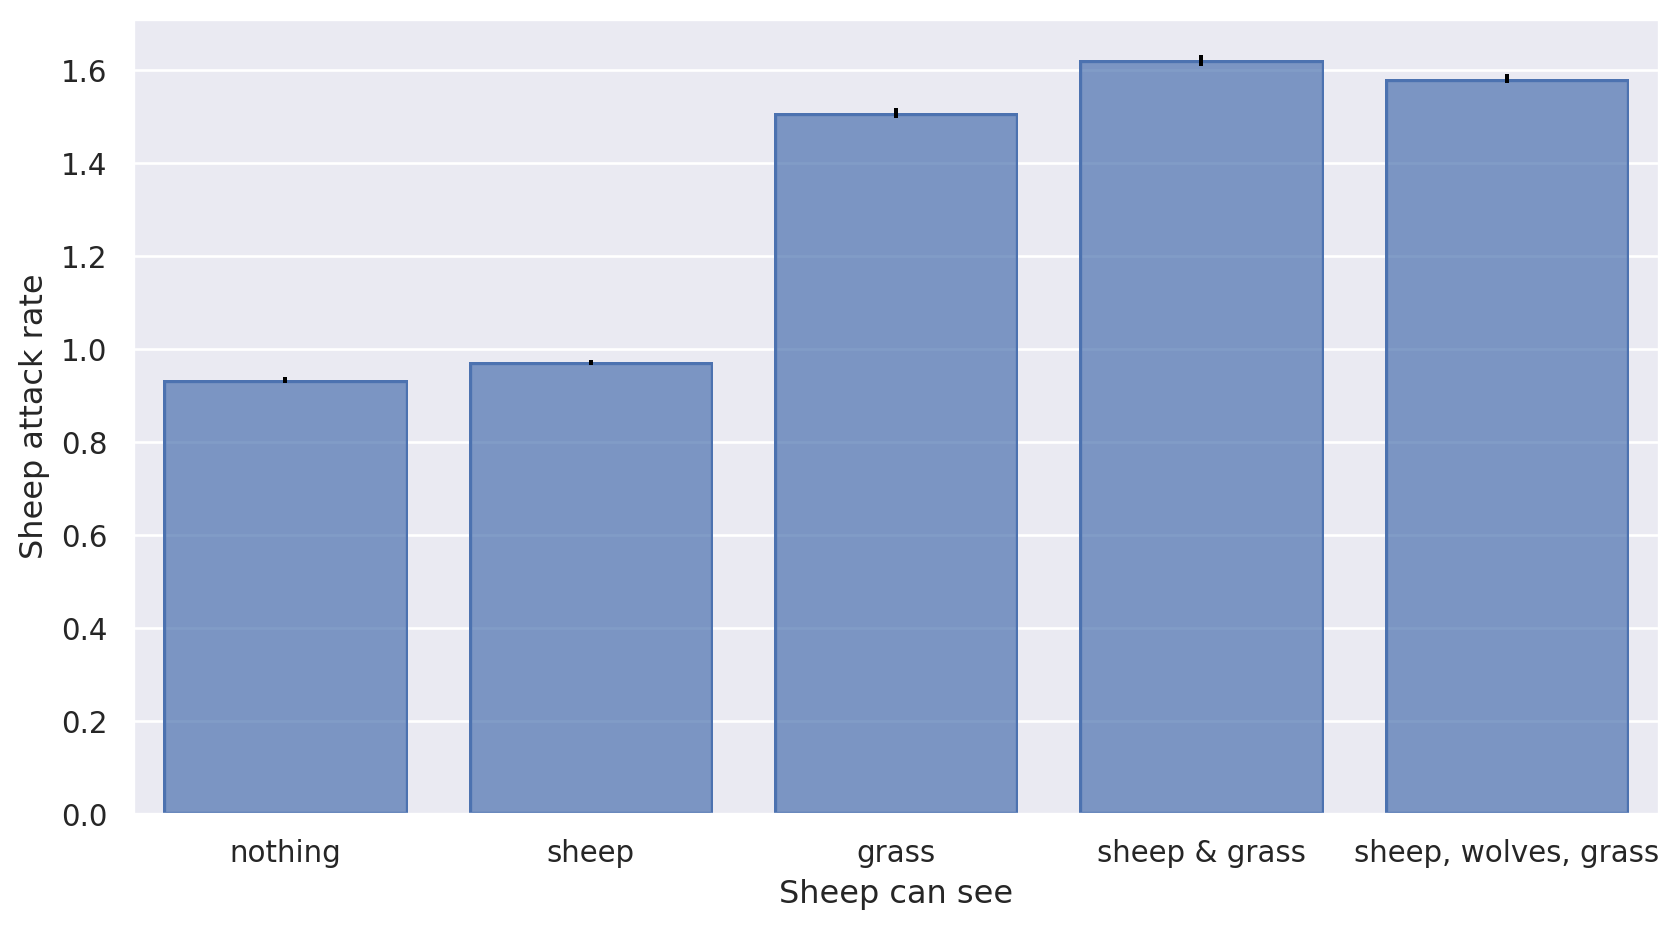

In [21]:
display(
    so.Plot(
        data=(
          wudf_run_no_wu
          .filter(
          (pl.col("wolves-see") == "swg")
          & (pl.col("sheep-see").is_in(["none", "s", "g", "sg", "swg"]))
        )
        .with_columns(sheep_see_readable=pl.col("sheep-see").map_dict({"none": "nothing", "s": "sheep", "g": "grass", "sg": "sheep & grass", "swg": "sheep, wolves, grass"}))
        ), y="sheep-efficiency", x="sheep_see_readable",
    )
    .add(so.Bar(), so.Agg(), so.Dodge())
    .add(so.Range(color="black"), so.Est(), so.Dodge())
    .label(y="Sheep attack rate", x="Sheep can see")
    .scale(x=so.Nominal(order=["nothing", "sheep", "grass", "sheep & grass", "sheep, wolves, grass"]))
    .layout(size=(9, 5))
)


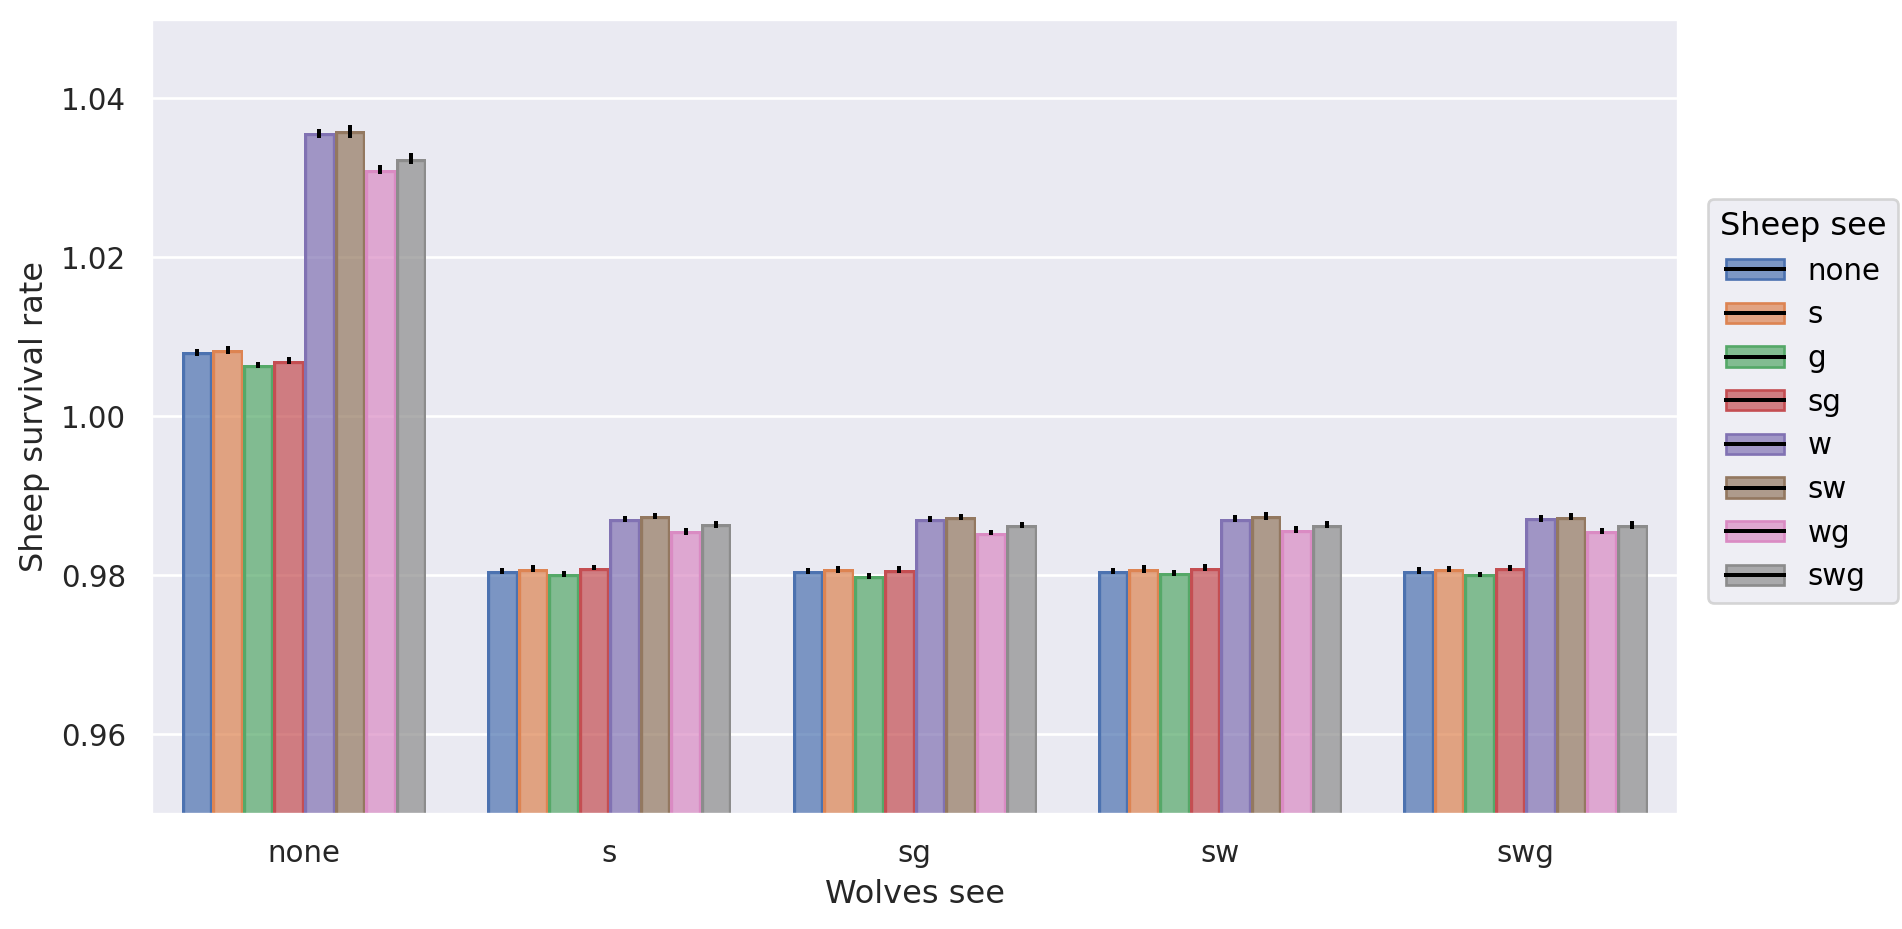

In [27]:
display(
    so.Plot(
        data=wudf_run_no_wu,
        y="wolf-efficiency",
        x="wolves-see",
        color="sheep-see",
    )
    .add(so.Bar(), so.Agg(), so.Dodge())
    .add(so.Range(color="black"), so.Est(), so.Dodge())
    .scale(x=so.Nominal(order=wso_eff), color=so.Nominal(order=sso_pop))
    .limit(y=(0.95, 1.05))
    .label(y="Sheep survival rate", x="Wolves see", color="Sheep see")
    .layout(size=(9, 5))
)


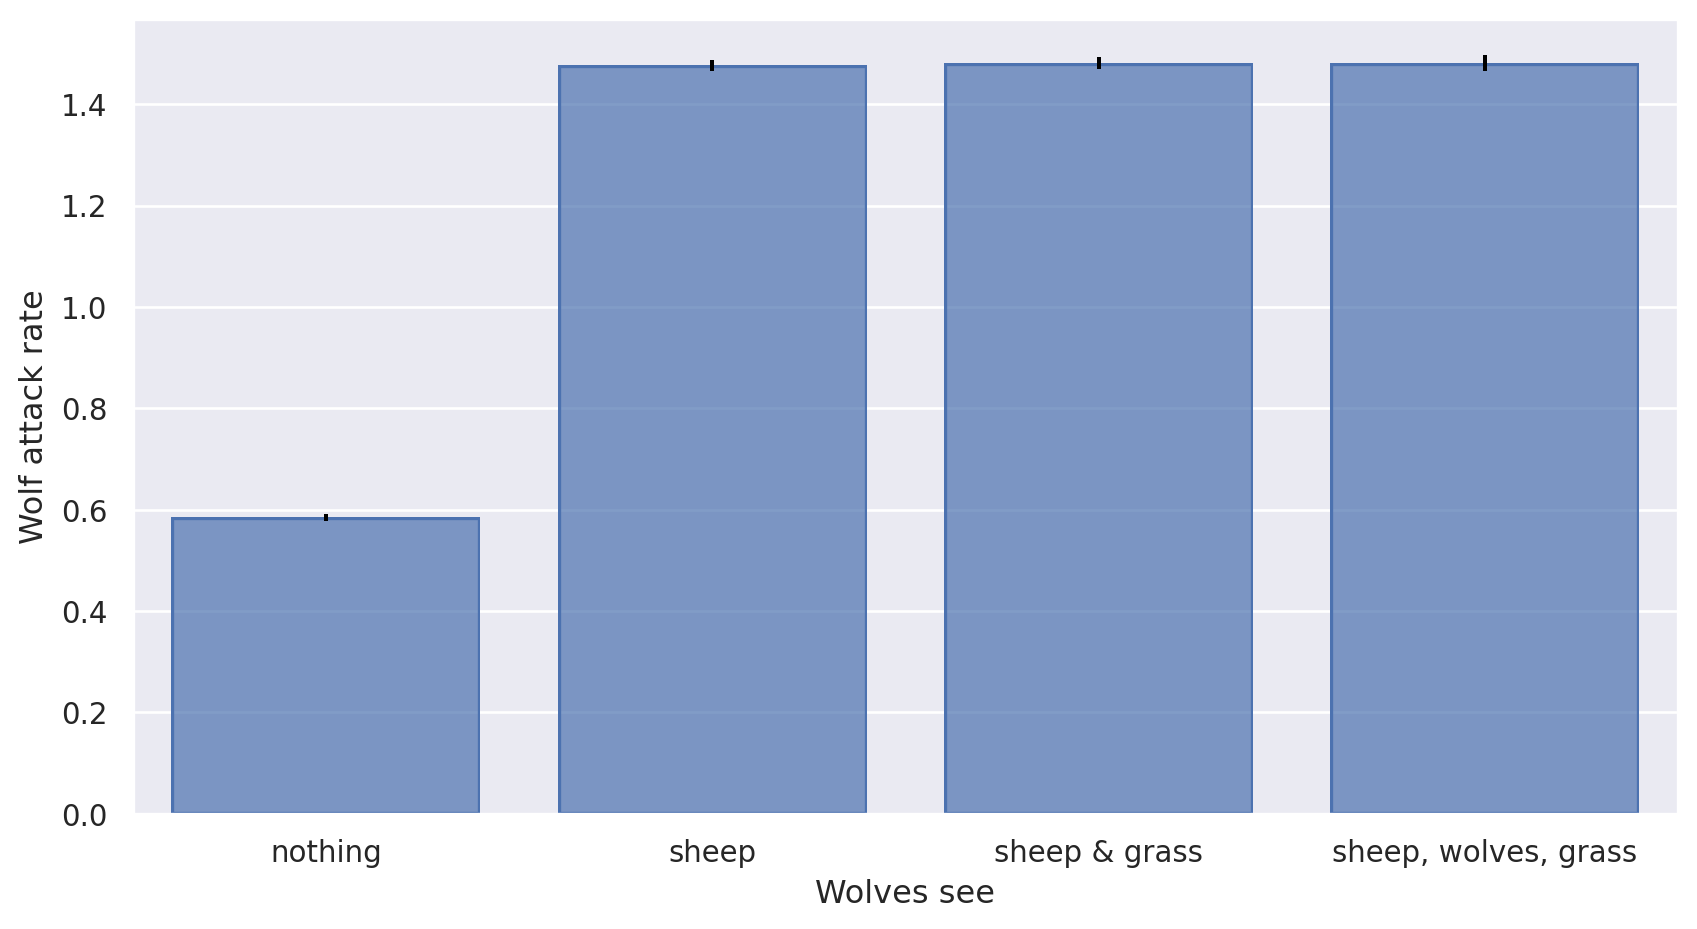

In [23]:
display(
    so.Plot(
        data=wudf_run_no_wu.filter(pl.col("sheep-see")=="swg").with_columns(wolves_see_readable=pl.col("wolves-see").map_dict({"none": "nothing", "s": "sheep", "g": "grass", "sg": "sheep & grass", "swg": "sheep, wolves, grass"})),
        y="wolf-efficiency",
        x="wolves_see_readable",
    )
    .add(so.Bar(), so.Agg(), so.Dodge())
    .add(so.Range(color="black"), so.Est(), so.Dodge())
    .scale(x=so.Nominal(order=["nothing", "sheep", "sheep & grass", "sheep, wolves, grass"]))
    # .limit(y=(0.95, 1.05))
    .label(y="Wolf attack rate", x="Wolves see")
    .layout(size=(9, 5))
)


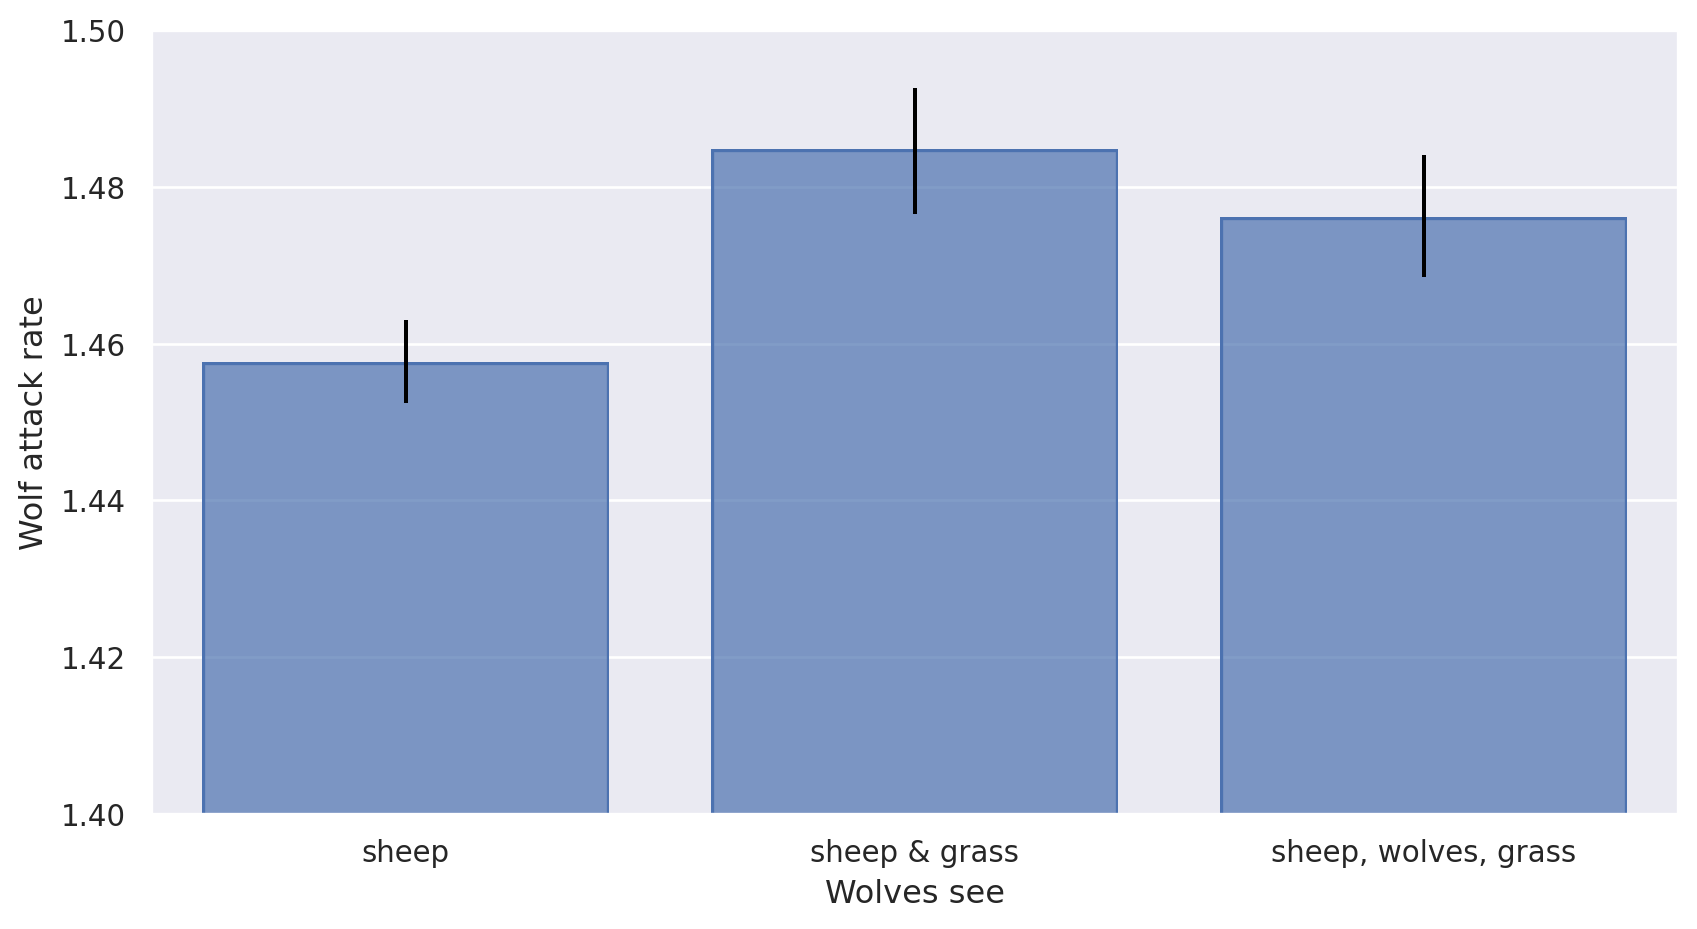

In [30]:
display(
    so.Plot(
        data=wudf_runs.filter(pl.col("sheep-see")=="swg").with_columns(wolves_see_readable=pl.col("wolves-see").map_dict({"none": "nothing", "s": "sheep", "g": "grass", "sg": "sheep & grass", "swg": "sheep, wolves, grass"})),
        y="wolf-efficiency",
        x="wolves_see_readable",
    )
    .add(so.Bar(), so.Agg(), so.Dodge())
    .add(so.Range(color="black"), so.Est(), so.Dodge())
    .scale(x=so.Nominal(order=["sheep", "sheep & grass", "sheep, wolves, grass"]))
    .limit(y=(1.4, 1.5))
    .label(y="Wolf attack rate", x="Wolves see")
    .layout(size=(9, 5))
)

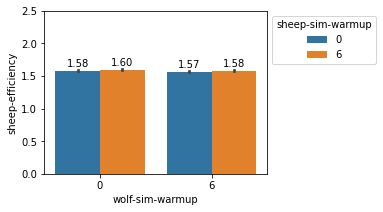

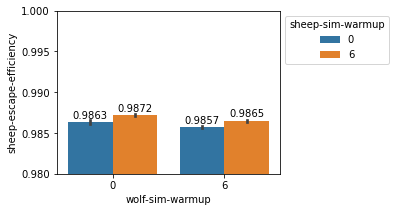

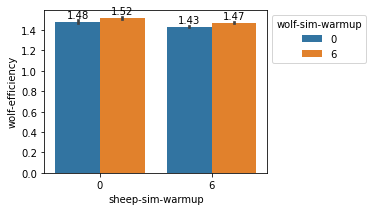

In [151]:
wu_see_all = wudf_runs.filter((pl.col("sheep-see")=="swg") & (pl.col("wolves-see")=="swg"))

plt.figure(figsize=(4,3))
ax = sns.barplot(
    wu_see_all.to_pandas(),
    hue="sheep-sim-warmup",
    y="sheep-efficiency",
    x="wolf-sim-warmup",
    palette=sns.color_palette(),
)
for b in ax.containers:
    ax.bar_label(b, fmt="%.2f", padding=2)
ax.set_ylim((0, 2.5))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.figure(figsize=(4,3))
ax = sns.barplot(
    wu_see_all.to_pandas(),
    hue="sheep-sim-warmup",
    y="sheep-escape-efficiency",
    x="wolf-sim-warmup",
    palette=sns.color_palette(),
)
for b in ax.containers:
    ax.bar_label(b, fmt="%.4f", padding=2)
ax.set_ylim((0.98, 1.00))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.figure(figsize=(4,3))
ax = sns.barplot(
    wu_see_all.to_pandas(),
    x="sheep-sim-warmup",
    y="wolf-efficiency",
    hue="wolf-sim-warmup",
    palette=sns.color_palette(),
)
for b in ax.containers:
    ax.bar_label(b, fmt="%.2f", padding=2)
#ax.set_ylim((0, 1.0))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


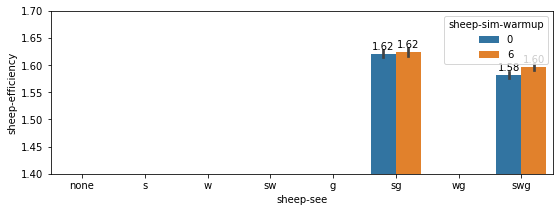

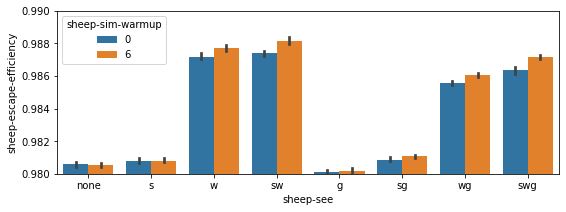

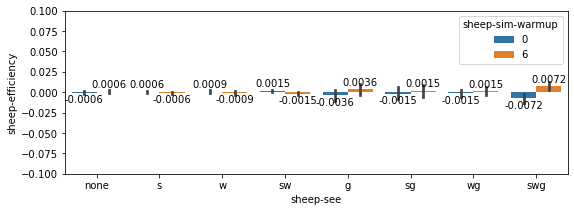

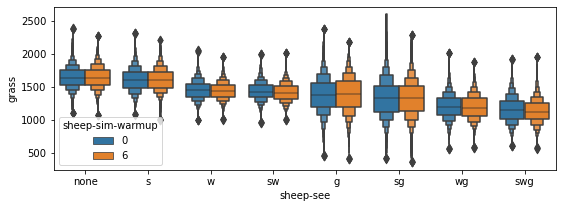

In [288]:
plt.figure(figsize=(9, 3))
ax = sns.barplot(
    wudf_runs.filter(
        (pl.col("wolf-sim-warmup") == 0) & (pl.col("wolves-see") == "swg")
        & (pl.col("sheep-see").str.contains("s"))
    ).to_pandas(),
    x="sheep-see",
    y="sheep-efficiency",
    hue="sheep-sim-warmup",
    order=sheep_see_order,
)
for b in ax.containers:
    ax.bar_label(b, fmt="%.2f", padding=2)
ax.set_ylim((1.4, 1.7))

plt.figure(figsize=(9, 3))
ax = sns.barplot(
    wudf_runs.filter(
        (pl.col("wolf-sim-warmup") == 0) & (pl.col("wolves-see") == "swg")
    ).to_pandas(),
    x="sheep-see",
    y="sheep-escape-efficiency",
    hue="sheep-sim-warmup",
    order=sheep_see_order,
)
ax.set_ylim((0.98, 0.99))

plt.figure(figsize=(9, 3))
ax = sns.barplot(
    wudf_runs.filter((pl.col("wolf-sim-warmup") == 0) & (pl.col("wolves-see") == "swg"))
    .with_columns(
        ((pl.col("sheep-efficiency") - pl.mean("sheep-efficiency"))).over("sheep-see")
        

    )
    .to_pandas(),
    x="sheep-see",
    y="sheep-efficiency",
    hue="sheep-sim-warmup",
    order=sheep_see_order,
)
for b in ax.containers:
    ax.bar_label(b, fmt="%.4f", padding=2)
ax.set_ylim((-.1, 0.1))

plt.figure(figsize=(9, 3))
ax = sns.boxenplot(
    wudf.filter(
        (pl.col("[step]") > 1000)
        & (pl.col("wolf-sim-warmup") == 0)
        & (pl.col("wolves-see") == "swg")
    ).to_pandas(),
    x="sheep-see",
    y="grass",
    hue="sheep-sim-warmup",
    order=sheep_see_order,
)


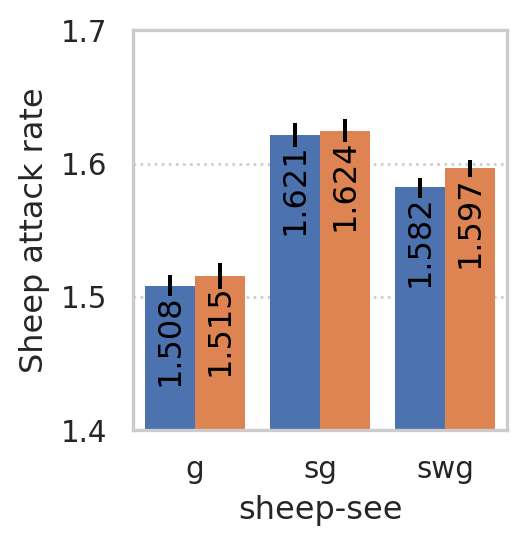

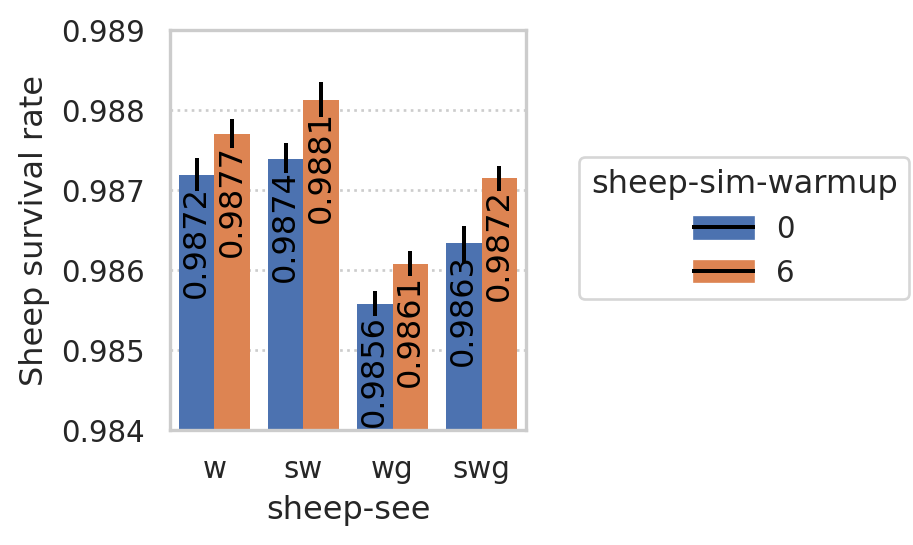

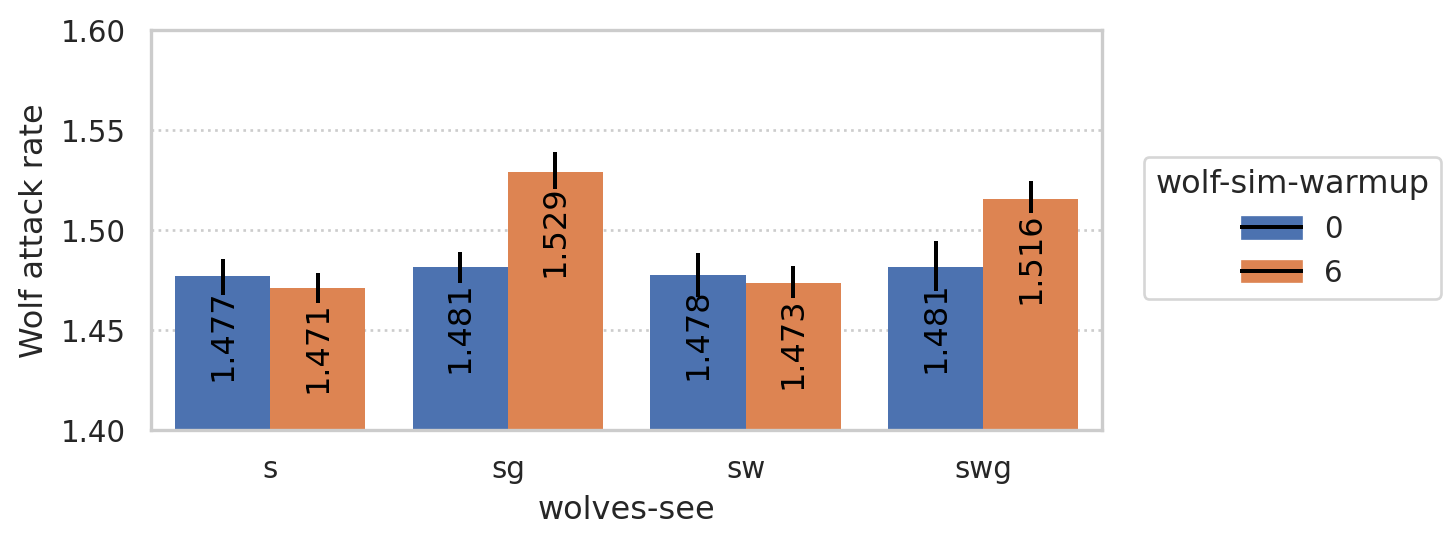

In [105]:
display(
    plot_eff_over_sees(
        wudf_runs.filter(
            (pl.col("wolf-sim-warmup") == 0) & (pl.col("wolves-see") == "swg")
        ),
        ("sheep-efficiency", "Sheep attack rate"),
        ("sheep-see", ["g", "sg", "swg"]),
        ("sheep-sim-warmup", [0, 6]),
        offset=3,
        fontsize=12,
        figsize=(3, 3),
        legend=False,
    )
    .limit(y=(1.4, 1.7))
    .save("images/microsims_warmup_exp_sheep_eff.png", bbox_inches="tight", dpi=300)
)
display(
    plot_eff_over_sees(
        wudf_runs.filter(
            (pl.col("wolf-sim-warmup") == 0) & (pl.col("wolves-see") == "swg")
        ),
        ("sheep-escape-efficiency", "Sheep survival rate"),
        ("sheep-see", ["w", "sw", "wg", "swg"]),
        ("sheep-sim-warmup", [0, 6]),
        offset=4,
        figsize=(3, 3),
        fontsize=12,
        precision=4,
    )
    .limit(y=(0.984, 0.989))
    .save("images/microsims_warmup_exp_sheep_esc_eff.png", bbox_inches="tight", dpi=300)
)

display(
    plot_eff_over_sees(
        wudf_runs.filter(
            (pl.col("sheep-sim-warmup") == 0) & (pl.col("sheep-see") == "swg")
        ),
        ("wolf-efficiency", "Wolf attack rate"),
        ("wolves-see", ["s", "sg", "sw", "swg"]),
        ("wolf-sim-warmup", [0, 6]),
        figsize=(6, 3),
        fontsize=12,
        offset=5,
    )
    .limit(y=(1.4, 1.6))
    .save("images/microsims_warmup_exp_wolf_eff.png", bbox_inches="tight", dpi=300)
)